In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [29]:
# Define file paths
housing_path = '../Data/Housing Updated 2.csv'
rental_path = '../Data/Rental Updated 2.csv'

# Load datasets
# Note: Assuming the files are in the 'Data' directory relative to the 'Notebook' directory
df_housing_raw = pd.read_csv(housing_path)
df_rental_raw = pd.read_csv(rental_path)

print("Housing Data Shape:", df_housing_raw.shape)
print("Rental Data Shape:", df_rental_raw.shape)

Housing Data Shape: (26309, 319)
Rental Data Shape: (7822, 139)


In [30]:
def clean_zillow_data(df, value_name):
    # Identify date columns (columns that are not metadata)
    # Metadata columns usually include RegionID, RegionName, City, State, Metro, CountyName, etc.
    # We'll assume any column that looks like a date is a date column.
    # Based on file inspection, the first few columns are metadata.
    
    # Let's identify ID columns. 
    # Common columns in Zillow data: RegionID, SizeRank, RegionName, RegionType, StateName, State, City, Metro, CountyName
    # Heuristic: date columns start with a digit (e.g., '2015-01-31' or '1/31/2000')
    id_vars = [c for c in df.columns if not c[0].isdigit()] 
    
    # Melt the dataframe
    df_melted = df.melt(id_vars=id_vars, var_name='Date', value_name=value_name)
    
    # Convert Date to datetime
    df_melted['Date'] = pd.to_datetime(df_melted['Date'])
    
    # Filter for dates from January 2019 to present
    df_filtered = df_melted[df_melted['Date'] >= '2019-01-01']
    
    return df_filtered

# Clean both datasets
df_housing = clean_zillow_data(df_housing_raw, 'Price')
df_rental = clean_zillow_data(df_rental_raw, 'Rent')

print("Cleaned Housing Data Head:")
print(df_housing.head())
print("\nCleaned Rental Data Head:")
print(df_rental.head())

Cleaned Housing Data Head:
         RegionID  SizeRank  RegionName RegionType StateName State      City  \
5998452     91982         1       77494        zip        TX    TX      Katy   
5998453     61148         2        8701        zip        NJ    NJ  Lakewood   
5998454     91940         3       77449        zip        TX    TX      Katy   
5998455     62080         4       11368        zip        NY    NY  New York   
5998456     91733         5       77084        zip        TX    TX   Houston   

                                         Metro        CountyName       Date  \
5998452   Houston-The Woodlands-Sugar Land, TX  Fort Bend County 2019-01-31   
5998453  New York-Newark-Jersey City, NY-NJ-PA      Ocean County 2019-01-31   
5998454   Houston-The Woodlands-Sugar Land, TX     Harris County 2019-01-31   
5998455  New York-Newark-Jersey City, NY-NJ-PA     Queens County 2019-01-31   
5998456   Houston-The Woodlands-Sugar Land, TX     Harris County 2019-01-31   

                 

In [31]:
# Perform Inner Join
# We join on RegionName (Zip Code), City, and Metro. 
# Note: RegionName in Zillow data is often the Zip Code.
# We also need to join on Date to align the time series.

merge_keys = ['RegionName', 'City', 'Metro', 'Date']

# Ensure the keys exist in both (handling potential missing columns or naming differences if any, but assuming standard Zillow format)
# Based on user prompt: RegionName, City, Metro are present.

df_merged = pd.merge(df_housing, df_rental, on=merge_keys, how='inner')

# Drop rows where Rent or Price is null
df_merged = df_merged.dropna(subset=['Price', 'Rent'])

print("Merged Data Shape:", df_merged.shape)
print(df_merged.head())

Merged Data Shape: (333963, 18)
   RegionID_x  SizeRank_x  RegionName RegionType_x StateName_x State_x  \
0       91982           1       77494          zip          TX      TX   
2       91940           3       77449          zip          TX      TX   
4       91733           5       77084          zip          TX      TX   
6       62093           7       11385          zip          NY      NY   
7       92593           8       78660          zip          TX      TX   

           City                                  Metro      CountyName_x  \
0          Katy   Houston-The Woodlands-Sugar Land, TX  Fort Bend County   
2          Katy   Houston-The Woodlands-Sugar Land, TX     Harris County   
4       Houston   Houston-The Woodlands-Sugar Land, TX     Harris County   
6      New York  New York-Newark-Jersey City, NY-NJ-PA     Queens County   
7  Pflugerville       Austin-Round Rock-Georgetown, TX     Travis County   

        Date          Price  RegionID_y  SizeRank_y RegionType_y S

In [32]:
# 1. Price-to-Rent Ratio
# Formula: Price / (Rent * 12)
df_merged['Price_to_Rent_Ratio'] = df_merged['Price'] / (df_merged['Rent'] * 12)

# 2. Year-Over-Year Growth
# Sort by RegionName and Date to ensure correct calculation
df_merged = df_merged.sort_values(by=['RegionName', 'Date'])

# Calculate pct_change(12) grouped by RegionName
df_merged['Price_YoY_Growth'] = df_merged.groupby('RegionName')['Price'].pct_change(12) * 100
df_merged['Rent_YoY_Growth'] = df_merged.groupby('RegionName')['Rent'].pct_change(12) * 100

print("Feature Engineering Complete. Head:")
print(df_merged[['Date', 'RegionName', 'Price', 'Rent', 'Price_to_Rent_Ratio', 'Price_YoY_Growth', 'Rent_YoY_Growth']].tail())

Feature Engineering Complete. Head:
             Date  RegionName          Price         Rent  \
604264 2025-06-30       99801  465684.697258  2057.098612   
612057 2025-07-31       99801  467517.738832  2044.320414   
619850 2025-08-31       99801  468294.848236  2074.051860   
627643 2025-09-30       99801  468197.025557  2012.615110   
635436 2025-10-31       99801  468738.041168  1996.000000   

        Price_to_Rent_Ratio  Price_YoY_Growth  Rent_YoY_Growth  
604264            18.864948               NaN              NaN  
612057            19.057586               NaN              NaN  
619850            18.815620               NaN              NaN  
627643            19.385932               NaN              NaN  
635436            19.569891               NaN              NaN  


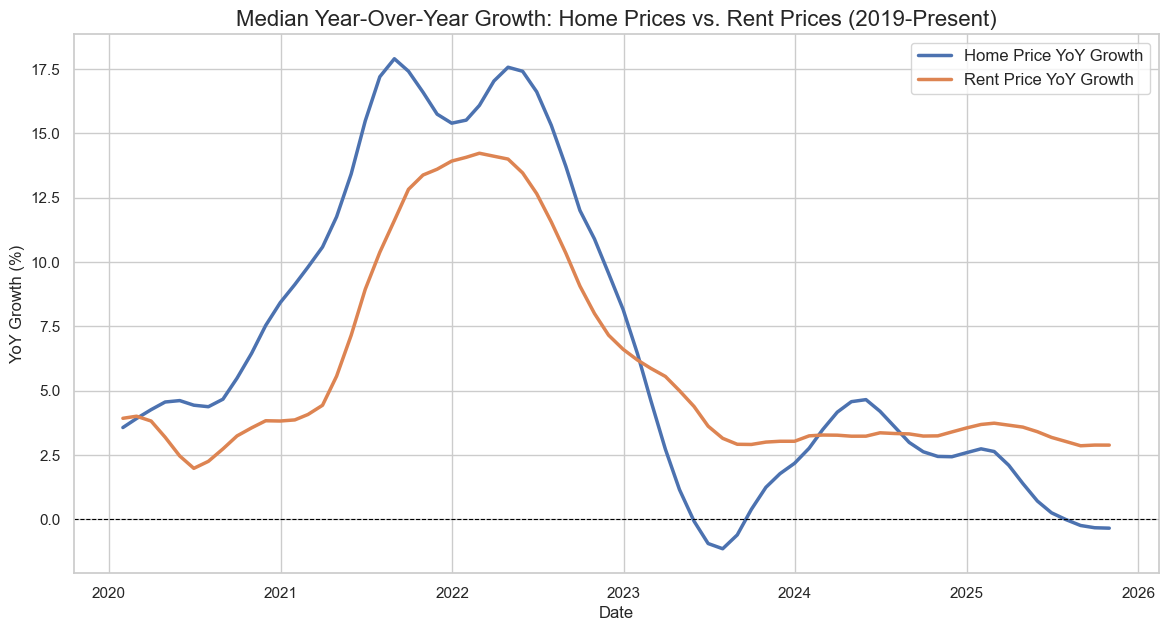

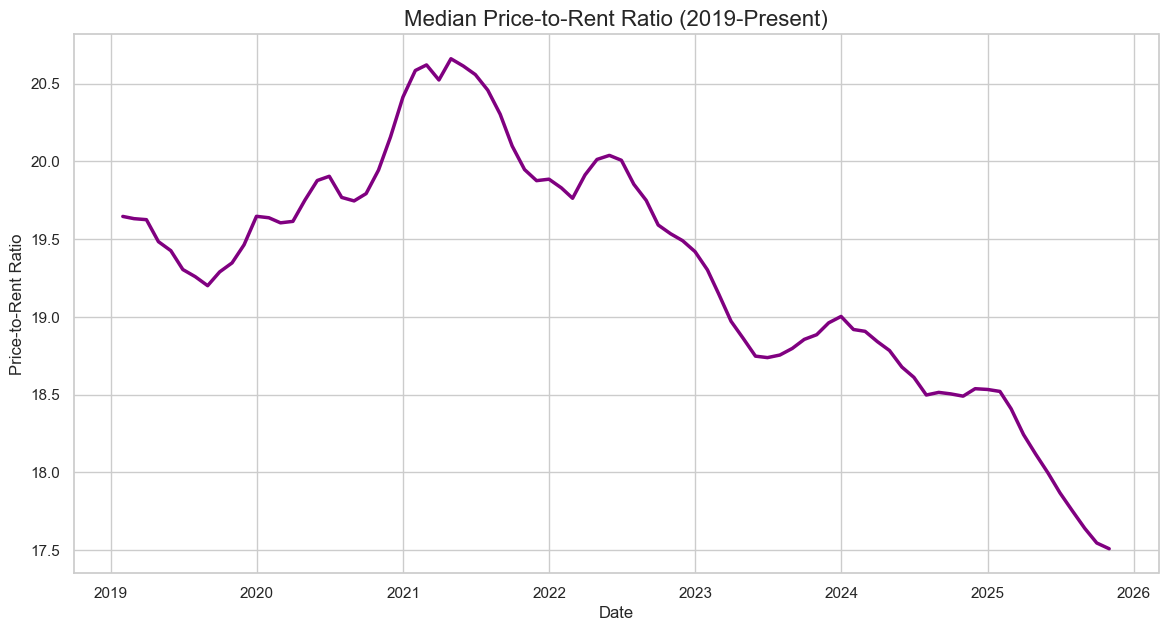

In [33]:
# 1. Line Chart: Median YoY Growth (Price vs Rent)
# Calculate median across all zip codes for each date
median_growth = df_merged.groupby('Date')[['Price_YoY_Growth', 'Rent_YoY_Growth']].median().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(median_growth['Date'], median_growth['Price_YoY_Growth'], label='Home Price YoY Growth', linewidth=2.5)
plt.plot(median_growth['Date'], median_growth['Rent_YoY_Growth'], label='Rent Price YoY Growth', linewidth=2.5)

plt.title('Median Year-Over-Year Growth: Home Prices vs. Rent Prices (2019-Present)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('YoY Growth (%)', fontsize=12)
plt.legend(fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--') # Zero line
plt.show()

# 2. Line Chart: Median Price-to-Rent Ratio
median_pr_ratio = df_merged.groupby('Date')['Price_to_Rent_Ratio'].median().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(median_pr_ratio['Date'], median_pr_ratio['Price_to_Rent_Ratio'], color='purple', linewidth=2.5)

plt.title('Median Price-to-Rent Ratio (2019-Present)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price-to-Rent Ratio', fontsize=12)
plt.show()

In [34]:
# Correlation between Rental Growth and Home Price Growth for 2024
# Filter for 2024
df_2024 = df_merged[df_merged['Date'].dt.year == 2024]

# Calculate correlation
correlation = df_2024['Rent_YoY_Growth'].corr(df_2024['Price_YoY_Growth'])

print(f"Correlation between Rental Growth and Home Price Growth in 2024: {correlation:.4f}")

Correlation between Rental Growth and Home Price Growth in 2024: 0.2881
